In [1]:
import os
os.chdir('E:/sandy/drop out ratio')

In [23]:
#importing data set
import pandas as pd
df = pd.read_csv('MOOC_Visual.csv')

In [24]:
df['startdate'] = pd.to_datetime(df['startdate'])
df['enddate'] = pd.to_datetime(df['enddate'])

df['start_year'] = df['startdate'].dt.year
df['start_month'] = df['startdate'].dt.month
df['end_year'] = df['enddate'].dt.year
df['end_month'] = df['enddate'].dt.month

In [25]:
#dropping startdate and enddate column 
df.drop(['startdate', 'enddate'],axis = 1,inplace = True)

## HANDLING imalanced dataset

In [83]:
#usin SMOTETOMEK technique 
from imblearn.combine import SMOTETomek
from collections import Counter 
os = SMOTETomek(0.5)
X,y = os.fit_sample(df.drop(['dropout_prob','enrollment_id'],axis = 1),df['dropout_prob'])
print(Counter(y))


C:\Users\DEEPANKAR\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


Counter({1: 56185, 0: 27485})


## HANDLING FEATURES

In [84]:
from sklearn.preprocessing import StandardScaler

In [85]:
stand = StandardScaler()
X = stand.fit_transform(X)

In [ ]:
#DEALIN OUTLIERS
x = 'user_enroll'
#Figure = df.boxplot(column = x)
upper_bound2 = df[x].mean()+3*df[x].std()
lower_bound2 = df[x].mean()-3*df[x].std()

#IQR

IQR = df[x].quantile(0.75)-df[x].quantile(0.25)
lower1 = df[x].quantile(0.25)-3*(IQR)
upper1 = df[x].quantile(0.75)+3*(IQR)


In [ ]:
import numpy as np

X.loc[X['navigate']> 46.25,'navigate'] = 46.25
X.loc[X['discussion']> 10,'discussion'] = 10
X.loc[X['access']> 101,'access'] = 101
X.loc[X['page_close']> 36,'page_close'] = 36
X.loc[X['problem']> 24,'problem'] = 24
X.loc[X['video']> 24,'video'] = 24
X.loc[X['wiki']> 4,'wiki'] = 4
X.loc[X['proccess_period']> 39.72,'proccess_period'] = 39.72
X.loc[X['present_days']> 9,'present_days'] = 9
X.loc[X['effective_time']> 15,'effective_time'] = 15
X.loc[X['user_enroll']> 9,'user_enroll'] = 9
X['start_year'] = np.where(X['start_year']==2014,1,0)
X['end_year'] = np.where(X['end_year']==2014,1,0)

##  FEATURE SELECTION

In [ ]:
# Scoring features on basis of Importance using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesClassifier
selection = ExtraTreesClassifier()
selection.fit(X, y)

In [ ]:
#plot graph of feature importances for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [ ]:
feat_importances.nlargest(20).index

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
top_features = SelectKBest(score_func = chi2, k = 20)
ordered_feature = top_features.fit(X,y)
df_score = pd.DataFrame(ordered_feature.scores_, columns = ["scores"])
df_columns = pd.DataFrame(X.columns)
features_rank = pd.concat([df_columns,df_score],axis = 1)
features_rank.columns = ['Features','scores']
features_rank['scores'].sort()

In [86]:
#SPLITTIN DATA IN TEST AND TRAIN
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

(16742, 25)

## ## GRADBOOST ALGO

In [35]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection import cross_validate  
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
predictors = [x for x in df.columns if x not in ['dropout_prob','enrollment_id']]

In [36]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['dropout_prob'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['dropout_prob'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['dropout_prob'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['dropout_prob'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8732
AUC Score (Train): 0.875390
CV Score : Mean - 0.8713482 | Std - 0.006676924 | Min - 0.8608077 | Max - 0.8816361


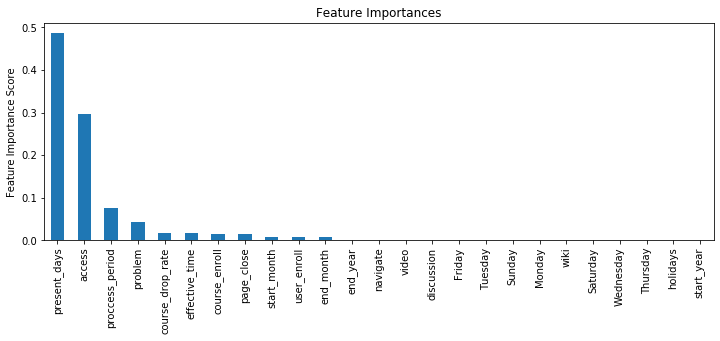

In [37]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, df, predictors)

In [90]:
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 81, 10)}, scoring='roc_auc')

In [91]:
gsearch1.best_params_

{'n_estimators': 80}

In [93]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 15, 'min_samples_split': 200}, 0.9295864468365105)

In [61]:
param_test3 = {'max_features':range(7,20,2), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15,min_samples_split = 200,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15,
                                                  max_features='sqrt',
                                                  min_samples_split=200,
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_features': range(7, 20, 2),
                         'min_samples_leaf': range(30, 71, 10)},
             scoring='roc_auc')

In [62]:
gsearch3.best_params_

{'max_features': 19, 'min_samples_leaf': 30}

Here we got max_features as 19, min_samples_leaf as 30 so we should try with lower value for min_samples_leaf and higher value for max_features 

In [57]:
param_test4 = {'max_features':range(7,40,2), 'min_samples_leaf':range(10,40,10)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15,min_samples_split = 200,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15,
                                                  max_features='sqrt',
                                                  min_samples_split=200,
                                                  n_estimators=60,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_features': range(7, 20, 2),
                         'min_samples_leaf': range(30, 71, 10)},
             scoring='roc_auc')

In [59]:
gsearch4.best_params_

{'max_features': 19, 'min_samples_leaf': 30}

In [68]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95,1,1.01,1.03,1.04]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15,min_samples_split=200, min_samples_leaf=30, subsample=0.8, random_state=10,max_features=19),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15, max_features=19,
                                                  min_samples_leaf=30,
                                                  min_samples_split=200,
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1,
                                       1.01, 1.03, 1.04]},
             scoring='roc_auc')

In [69]:
gsearch5.best_params_

{'subsample': 1}

In [71]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=80,max_depth=15, min_samples_split=200,min_samples_leaf=30, subsample=1, random_state=10, max_features=19)



Model Report
Accuracy : 0.9024
AUC Score (Train): 0.931865
CV Score : Mean - 0.8735627 | Std - 0.006528061 | Min - 0.863378 | Max - 0.8832473


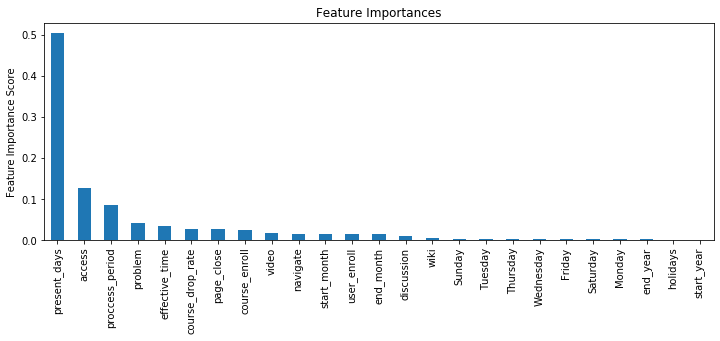

In [72]:
modelfit(gbm_tuned_1, df, predictors)

####  Finally, we have all the parameters needed. Now, we need to lower the learning rate and increase the number of estimators proportionally. Lets decrease the learning rate to half, i.e. 0.05 with twice (160) the number of trees. 


Model Report
Accuracy : 0.916
AUC Score (Train): 0.943057
CV Score : Mean - 0.8741185 | Std - 0.006705085 | Min - 0.8634385 | Max - 0.8836704


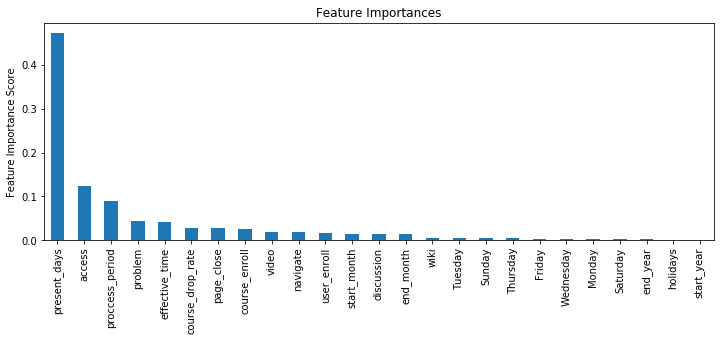

In [95]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160,max_depth=15, min_samples_split=200,min_samples_leaf=30, subsample=1, random_state=10, max_features=19)
modelfit(gbm_tuned_2, df, predictors)

    #### Now lets reduce to one-tenth of the original value, i.e. 0.01 for 800 trees.


Model Report
Accuracy : 0.9149
AUC Score (Train): 0.942987
CV Score : Mean - 0.8744707 | Std - 0.006928368 | Min - 0.8634006 | Max - 0.884171


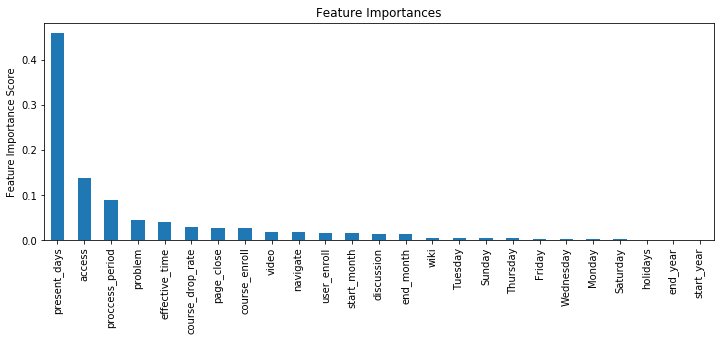

In [96]:
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=800,max_depth=15, min_samples_split=200,min_samples_leaf=30, subsample=1, random_state=10, max_features=19)
modelfit(gbm_tuned_3, df, predictors)

In [79]:
gbm_tuned_1.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=15, max_features=19,
                           min_samples_leaf=30, min_samples_split=200,
                           n_estimators=80, random_state=10, subsample=1)

In [82]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predict2))
print(metrics.accuracy_score(y_test,predict2))
print(metrics.classification_report(y_test,predict2))
print(metrics.f1_score(y_test,predict2))

[[ 4295  1234]
 [  672 10541]]
0.8861545812925576
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      5529
           1       0.90      0.94      0.92     11213

    accuracy                           0.89     16742
   macro avg       0.88      0.86      0.87     16742
weighted avg       0.89      0.89      0.88     16742

0.9170871759178701


In [ ]:
#After standardization

In [87]:
gbm_tuned_1.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=15, max_features=19,
                           min_samples_leaf=30, min_samples_split=200,
                           n_estimators=80, random_state=10, subsample=1)

In [88]:
predict2 = gbm_tuned_1.predict(X_test)

In [89]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predict2))
print(metrics.accuracy_score(y_test,predict2))
print(metrics.classification_report(y_test,predict2))
print(metrics.f1_score(y_test,predict2))

[[ 4261  1166]
 [  713 10594]]
0.8877136369068961
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      5427
           1       0.90      0.94      0.92     11307

    accuracy                           0.89     16734
   macro avg       0.88      0.86      0.87     16734
weighted avg       0.89      0.89      0.89     16734

0.9185416395716824
